_ATU Donegal - MSc in Data Science: Machine Learning_
**<h1>Lab 5: Conditional Probability and Naive Bayes Classifiers</h1>**

In this notebook, we'll use sklearn's multinomial Naive Bayes model to train a spam classifier, and then to train a model to predict review sentiment on the IMDB dataset. As with most projects, the initial code deals with loading the training data into a pandas DataFrame. The first cells download the dataset of messages we'll use and create a data frame from it.

In [1]:
%%capture
!wget https://github.com/paulgreaney/data/raw/main/SMSSpamCollection.tsv

In [2]:
import os
import io
import numpy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

data = pd.read_csv('SMSSpamCollection.tsv', sep="\t")

Let's have a look at that DataFrame:

In [3]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.isnull().sum()

label      0
message    0
dtype: int64

In [5]:
data["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

We can see that there are 5572 messages, and 4825 are labelled as ham.

Therefore 4825 / 5572 = 86% of messages are ham. If we were to always choose the label *ham* when reviewing a message, then 86% would randomly be correct with this dataset. So our text classifier needs to perform better than 86% to beat the random selection model.

Now we will use a `CountVectorizer` to convert the collection of messages into a matrix of token counts, which we can then pass into the `fit_transform` method of a `MultinomialNB` classifier.

In [6]:
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(data['message'].values)

classifier = MultinomialNB()
targets = data['label'].values
classifier.fit(counts, targets)

MultinomialNB()

Let's try it out:

In [7]:
examples = ['see invoice attached', "Do you have that report for me?"]
example_counts = vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
predictions

array(['ham', 'ham'], dtype='<U4')

In [8]:
examples = ["send cash now", "subscribe now", "win a prize"]
example_counts = vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
predictions

array(['spam', 'spam', 'spam'], dtype='<U4')

In [9]:
# print(example_counts)

We can also print some of the messages which have been classified as spam:

In [10]:
for i in data['message'].values[:10]:
  pred = classifier.predict(vectorizer.transform([i]))
  if pred=='spam':
     print(i+'\n')

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.

Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030



### Train Test Split

Let's create our usual train/test split and measure the model performance.

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(data["message"])
y = np.array(data["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [12]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)

classifier = MultinomialNB()
classifier.fit(X_train_counts, y_train)

MultinomialNB()

In [13]:
from sklearn.metrics import accuracy_score
cv_model_train_score = accuracy_score(classifier.predict(X_train_counts), y_train)
cv_model_test_score = accuracy_score(classifier.predict(vectorizer.transform(X_test)), y_test)
print("Train score: ", cv_model_train_score)
print("Test score: ", cv_model_test_score)

Train score:  0.9948717948717949
Test score:  0.9754784688995215


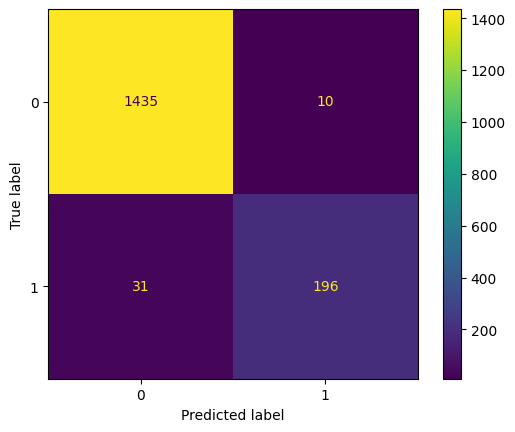

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1445
        spam       0.95      0.86      0.91       227

    accuracy                           0.98      1672
   macro avg       0.97      0.93      0.95      1672
weighted avg       0.98      0.98      0.97      1672



In [14]:
X_test_counts = vectorizer.transform(X_test)
predictions = classifier.predict(X_test_counts)
from sklearn import metrics
import matplotlib.pyplot as plt
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, predictions)).plot()
plt.show()
print(metrics.classification_report(y_test, predictions))

## Improving the Model: Using $N$-Grams
Our model is already very good, but there are some things we can still try with an eye towards reducing the false positives and false negatives enumerated in the confusion matrix. There are a number of approaches that can be used to improve model performance when working with text data. Two of these are TF-IDF and $n$-grams. TF-IDF works well for balanced datasets, where the split amongst classes is approximately equal, and is implemented in `TfidfVectorizer` (in place of `CountVectorizer`). We have a very imbalanced dataset here, so let's try the $n$-gram approach alone.

In [15]:
ngram_vectorizer = CountVectorizer(ngram_range=(1,1))

X_train_ngram = ngram_vectorizer.fit_transform(X_train)

ngram_classifier = MultinomialNB()
ngram_classifier.fit(X_train_ngram, y_train)

from sklearn.metrics import accuracy_score
ngram_train_score = accuracy_score(ngram_classifier.predict(X_train_ngram), y_train)
ngram_test_score = accuracy_score(ngram_classifier.predict(ngram_vectorizer.transform(X_test)), y_test)
print("Train score: ", ngram_train_score)
print("Test score: ", ngram_test_score)

print("Change in train score wrt base model: ", 100*(ngram_train_score-cv_model_train_score))
print("Change in test score wrt base model: ", 100*(ngram_test_score-cv_model_test_score))

Train score:  0.9948717948717949
Test score:  0.9754784688995215
Change in train score wrt base model:  0.0
Change in test score wrt base model:  0.0


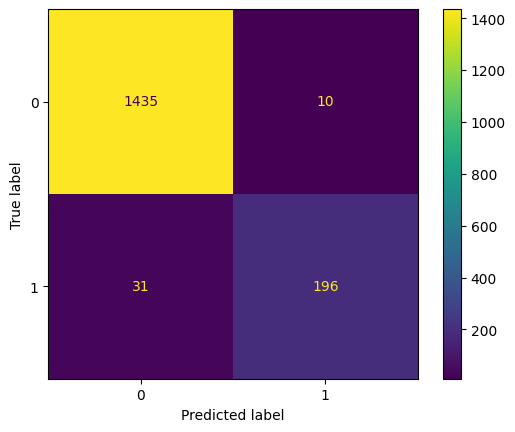

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1445
        spam       0.95      0.86      0.91       227

    accuracy                           0.98      1672
   macro avg       0.97      0.93      0.95      1672
weighted avg       0.98      0.98      0.97      1672

0.9754784688995215


In [16]:
X_test_ngram = ngram_vectorizer.transform(X_test)
predictions = ngram_classifier.predict(X_test_ngram)
from sklearn import metrics
import matplotlib.pyplot as plt
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, predictions)).plot()
plt.show()
print(metrics.classification_report(y_test, predictions))
print(metrics.accuracy_score(y_test, predictions))

Look at the values in the classification report above, and compare with the report for the previous model. You should see an improvement on recall for the ham class, and a drop in recall for the spam class.

Precision is the number of samples predicted for a class which are correct, so for ham it will be

$$
\text{Precision} = \frac{\text{Number of samples correctly predicted as ham}}{\text{Total number of samples predicted as ham}}.
$$

Recall is the number of samples in that class which are correctly predicted:

$$
\text{Recall} = \frac{\text{Number of samples correctly predicted as ham}}{\text{Total number of ham examples in set}}.
$$


The F1-score combines the precision and recall into a single metric:

$$
F1 = \frac{2\times\text{Precision}\times\text{Recall}}{\text{Precision}+\text{Recall}}.
$$

The other two metrics reported are macro average and weighted average. The macro average is the unweighted mean of the the quantities for the two classes. The weighted average weights the calculation using the proportion of samples in the two classes - this is reported in the _support_ column of the classification report.

In some cases precision/recall/F1-score will be more important for one class than another, so it's typically useful to examine all of these values.

Let's try another sample message to see if our model behaves as expected.

In [17]:
sample_text_message = ["You can win free cash! Text 23455."]
transformed_text = ngram_vectorizer.transform(sample_text_message)

model_output = ngram_classifier.predict(transformed_text)
print(model_output)

['spam']


### Creating a Pipeline

So far we've vectorised the training data, then built a multinomial Naive Bayes classifier, fitted it to the training data, and then transformed the testing data before it could be fed to the trained model for inference.

Scikit-learn offers a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class that behaves like a compound classifier, allowing us to pack several steps together into a single object. This means we can creat a *pipeline* to contain several objects on which we can call the same methods simultaneously.
Let's use a pipeline to complete the processes above in a more automated manner.

In the code block below, we create an object `text_classifier` which is a pipeline containing our two ingredients - `CountVectorizer` and `MultinomialNB`. When `text_classifier.fit(X_train, y_train)` is called, the pipeline takes in `X_train` data and fits the `CountVectorizer` model on it, then takes the output of this step and fits the `MultinomialNB` on that. The combined model is then stored in memory.

When `text_classifier.predict(X_test)` is called, `X_text` is first transformed  with `count_vect` and then the `NB_classifier` is used to predict using the vectorised version of the `X_test` data.  All steps are performed within the `text_classifier` pipeline.

In [18]:
from sklearn.pipeline import Pipeline

# If we didn't have these libraries loaded then we should also do this
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.naive_bayes import MultinomialNB

text_classifier = Pipeline([('count_vect', CountVectorizer(ngram_range=(1,1))),
                     ('NB_classifier', MultinomialNB()),
])

# Feed the training data through the pipeline
text_classifier.fit(X_train, y_train)

Pipeline(steps=[('count_vect', CountVectorizer()),
                ('NB_classifier', MultinomialNB())])

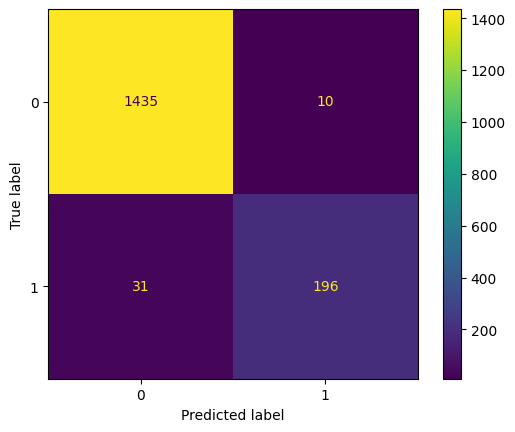

In [19]:
# Form a prediction set and report confusion matrix
predictions = text_classifier.predict(X_test)

from sklearn import metrics
import matplotlib.pyplot as plt
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, predictions)).plot()
plt.show()

## Exercises

Try building a similar model to classify the IMDB reviews dataset as positive or negative. Here the dataset is better balanced, so we can try `TfidfVectorizer` as well.

1. First create a pipeline using `CountVectorizer`, train the model on the resulting vectorised data, calculate the accuracy and obtain the confusion matrix.*

The code to create the DataFrame containing decoded reviews and labels is supplied below for convenience. Use different variable names to those above to avoid any confusion, or open a new notebook and write your code there instead. Note that the data is already vectorised when we download the dataset, so we can either use that directly or encode the decoded dataset.






In [20]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data,
                             test_labels) = imdb.load_data(num_words=30000)

17464789/17464789 [==============================] - 0s 0us/step


In [21]:
import spacy
nlp = spacy.load('en_core_web_sm')
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_reviews = []
for j in train_data:
  decoded_reviews.append(" ".join([reverse_word_index.get(i - 3, "?") for i in j]))



1641221/1641221 [==============================] - 0s 0us/step


In [22]:
# look at a sample review and its label
decoded_reviews[10], train_labels[10]

("? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and ? romance bursting on to the scene maléfique preceded the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made maléfique was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is complimented by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named carrère sent to prison for fraud he is put in a cell with three others the quietly insane lassalle body building transvestite marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old journal after translating part of it they soon realise its magical powers and re

In [23]:
# train_data
train_labels

array([1, 0, 0, ..., 0, 1, 0])

In [24]:
# decoded_reviews


In [25]:
text_classifier_keras = Pipeline([('count_vect', CountVectorizer(ngram_range=(1,1))),
                     ('NB_classifier', MultinomialNB()),
])

# Feed the training data through the pipeline
text_classifier_keras.fit(decoded_reviews, train_labels)

Pipeline(steps=[('count_vect', CountVectorizer()),
                ('NB_classifier', MultinomialNB())])

In [26]:
decoded_reviews_test = []

for j in test_data:
  decoded_reviews_test.append(" ".join([reverse_word_index.get(i - 3, "?") for i in j]))

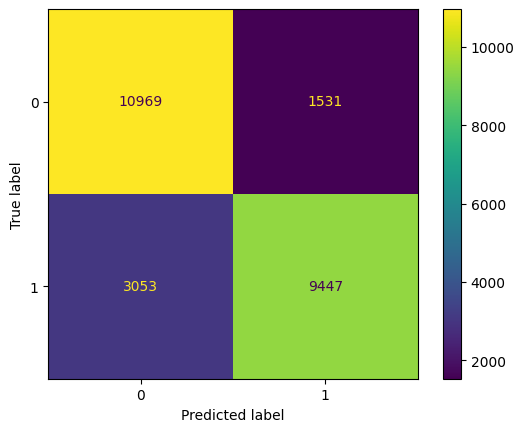

In [27]:
predictions = text_classifier_keras.predict(decoded_reviews_test)

from sklearn import metrics
import matplotlib.pyplot as plt
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_labels, predictions)).plot()
plt.show()

In [28]:
print(f"Test Accuracy = {accuracy_score(test_labels,predictions)}")
print(f"Train Accuracy = {accuracy_score(train_labels,text_classifier_keras.predict(decoded_reviews))}")


Test Accuracy = 0.81664
Train Accuracy = 0.87868


2. Then create a second pipeline using `TfidfVectorizer` instead of `CountVectorizer` and determine if this improves your results by comparing the accuracy and confusion matrices.*

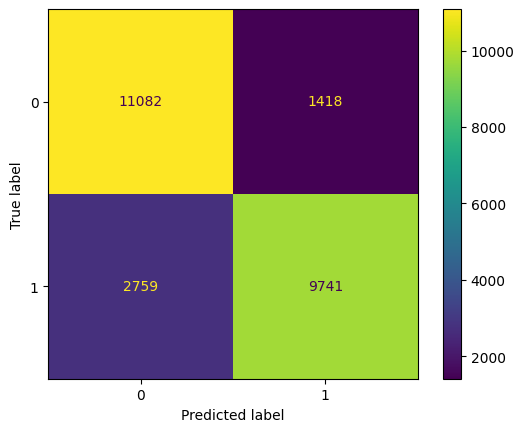

In [29]:

from sklearn.feature_extraction.text import TfidfVectorizer

text_classifier_TfidfVectorizer = Pipeline([('tfid_vect', TfidfVectorizer(ngram_range=(1,1))),
                     ('NB_classifier', MultinomialNB()),
])

# Feed the training data through the pipeline
text_classifier_TfidfVectorizer.fit(decoded_reviews, train_labels)
predictions = text_classifier_TfidfVectorizer.predict(decoded_reviews_test)

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_labels, predictions)).plot()
plt.show()

In [30]:
print(f"Test Accuracy = {accuracy_score(test_labels,predictions)}")
print(f"Train Accuracy = {accuracy_score(train_labels,text_classifier_TfidfVectorizer.predict(decoded_reviews))}")

# Yes the accuracy is increasing not more but littilbit

Test Accuracy = 0.83292
Train Accuracy = 0.89932


3. The accuracy can be improved by using the $n$-gram approach. Try changing this by passing `ngram_range` when initialising the `TfidfVectorizer`. The default is `ngram_range=(1,1)`.*

In [31]:
text_classifier_TfidfVectorizer = Pipeline([('tfid_vect', TfidfVectorizer(ngram_range=(2,3))),
                     ('NB_classifier', MultinomialNB()),
])

# Feed the training data through the pipeline
text_classifier_TfidfVectorizer.fit(decoded_reviews, train_labels)
predictions = text_classifier_TfidfVectorizer.predict(decoded_reviews_test)


print(f"Test Accuracy = {accuracy_score(test_labels,predictions)}")
print(f"Train Accuracy = {accuracy_score(train_labels,text_classifier_TfidfVectorizer.predict(decoded_reviews))}")


Test Accuracy = 0.88308
Train Accuracy = 0.99696


In [32]:
for i in range(1,4):
  for j in range(i,4):
    text_classifier_TfidfVectorizer = Pipeline([('tfid_vect', TfidfVectorizer(ngram_range=(i,j))),
                    ('NB_classifier', MultinomialNB()),
    ])

    # Feed the training data through the pipeline
    text_classifier_TfidfVectorizer.fit(decoded_reviews, train_labels)
    predictions = text_classifier_TfidfVectorizer.predict(decoded_reviews_test)

    print(f"({i},{j})")
    print(f"Test Accuracy = {accuracy_score(test_labels,predictions)}")
    print(f"Train Accuracy = {accuracy_score(train_labels,text_classifier_TfidfVectorizer.predict(decoded_reviews))}")
    print("___________________________________________")


(1,1)
Test Accuracy = 0.83292
Train Accuracy = 0.89932
___________________________________________
(1,2)
Test Accuracy = 0.8686
Train Accuracy = 0.96744
___________________________________________
(1,3)
Test Accuracy = 0.87816
Train Accuracy = 0.9898
___________________________________________
(2,2)
Test Accuracy = 0.87888
Train Accuracy = 0.98788
___________________________________________
(2,3)
Test Accuracy = 0.88308
Train Accuracy = 0.99696
___________________________________________
(3,3)
Test Accuracy = 0.87044
Train Accuracy = 0.99964
___________________________________________


### Optional Exercise
The dataset loaded by the cells below contains labelled emails, some of which have metadata (to/from/date information, newline characters, symbols). Try to figure out how to clean this data and then use it to create a Naive Bayes classifier. What effect does cleaning have on the model performance?

In [33]:
%%capture
!wget https://github.com/paulgreaney/data/raw/main/emails.zip
!unzip emails.zip

In [34]:
import os
import io
import numpy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def read_files(path):
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root, filename)

            in_body = False
            lines = []
            f = io.open(path, 'r', encoding='latin1')
            for line in f:
                if in_body:
                    lines.append(line)
                elif line == '\n':
                    in_body = True
            f.close()
            message = '\n'.join(lines)
            yield path, message


def data_frame_from_directory(path, classification):
    rows = []
    index = []
    for filename, message in read_files(path):
        rows.append({'message': message, 'class': classification})
        index.append(filename)

    return pd.DataFrame(rows, index=index)

data = pd.DataFrame({'message': [], 'class': []})
data = pd.concat([data, data_frame_from_directory('emails/spam', 'spam')])
data = pd.concat([data, data_frame_from_directory('emails/ham', 'ham')])


In [49]:
d = {'spam':0,'ham':1}
data['class'] = data['class'].map(d)

In [50]:
data['class'].unique()

array([0, 1])

In [47]:
data[data['message'].str.contains('\n')]['message'].head()

emails/spam/00194.767c323b4ae7a4909397e42cbd0c56a4    ------=_NextPart_000_006C_6B8D6A65.3C3C56F\n\n...
emails/spam/00177.56ed33af0cb1d0f700cc2d26a866870b    <html>\n\n\n\n<head>\n\n<meta http-equiv=3D"Co...
emails/spam/00367.9688cdee9dfe720c297672c8f60d998f    ++++++++++++++++++++++++++++++++++++++++++++++...
emails/spam/00464.8240aba24840864cb7439fc03f94ef6e    Protect your financial well-being.\n\nPurchase...
emails/spam/00336.92409253178027f58e2c072a7e82791e    PGh0bWw+DQo8aGVhZD4NCjxtZXRhIGh0dHAtZXF1aXY9Ik...
Name: message, dtype: object

In [52]:
from sklearn.model_selection import train_test_split
X = data['message']
y = data['class']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.3,random_state=32)



In [54]:
text_classifier_keras = Pipeline([('count_vect', CountVectorizer(ngram_range=(1,1))),
                     ('NB_classifier', MultinomialNB()),
])

# Feed the training data through the pipeline
text_classifier_keras.fit(X_train, y_train)

data_pred = text_classifier_keras.predict(X_test)


print(f"Test Accuracy = {accuracy_score(y_test,data_pred)}")
print(f"Train Accuracy = {accuracy_score(y_train,text_classifier_keras.predict(X_train))}")

Test Accuracy = 0.9655555555555555
Train Accuracy = 0.9766666666666667
